# Entrenamiento
Se entrenan los modelos de gradient boosting (LightGBM).




In [1]:
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, fbeta_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean, stdev, median
from ast import literal_eval
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Carga del dataset

In [2]:
df = pd.read_pickle("../data/orig/FraudNLP_dataset.pkl")
print("dataset shape: ", df.shape)
action_vocab = pd.read_csv("../data/orig/vocab.csv")

# one line is broken, throw it away
broken_times = df[df.times.apply(lambda x: x[-1]!="]")]
assert broken_times.shape[0] == 1
assert broken_times.iloc[0].is_fraud==0

# ignore the single broken line
df = df[df.times.apply(lambda x: x[-1]=="]")]

#build the raw text, using the names and the (index-inverted) tokens 
action_names = action_vocab.Name.to_list()
id_to_action = {str(i):a for i,a in enumerate(action_names)}
action_to_id = {a:str(i) for i,a in enumerate(action_names)}

# Recall to cast the strings into lists
df.actions = df.actions.apply(literal_eval)

df["times"] = df.times.apply(literal_eval).apply(lambda x: [i/1000 for i in x])
df["Action time mean"] = df.times.apply(np.mean)
df["Action time std"] = df.times.apply(np.std)
df["log(amount)"] = df.Amount.apply(np.log)
df["Transaction Type"] = df.is_fraud.apply(lambda x: "Fraud" if x else "Non Fraud")
df["time_to_first_action"] = df.times.apply(lambda x: x[1] if len(x)>1 else 0)
df["actions_str"] = df.actions.apply(lambda x: " ".join([id_to_action[str(i[0])] for i in x if len(i)>0]))
df["total_time_to_transaction"] = df.times.apply(sum)/1000
df['actions'] = df['actions'].apply(lambda x: [item for sublist in x for item in sublist])
df.head(2)

dataset shape:  (105303, 9)


,actions,times,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud,Action time mean,Action time std,log(amount),Transaction Type,time_to_first_action,actions_str,total_time_to_transaction
1,"[22, 27, 24, 1, 1268, 1269, 1267, 22, 29, 1, 2...","[0.0, 33.204, 215.636, 443.415, 72.586, 34.241...",203,13,1.0,1.000000,0.500000,1.0,0,177.859292,218.368580,2.564949,Non Fraud,33.204,/PROFILE/GETCUSTOMERRESPONSE /TAXFREE/GETTAXGO...,4.268623
2,"[22, 24, 27, 1, 1268, 1269, 1267, 2, 23, 6, 25...","[0.0, 25.459, 46.236, 428.626, 42.785, 74.158,...",359,310,1.0,0.333333,0.333333,1.0,0,196.875569,252.496316,5.736572,Non Fraud,25.459,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,587.279823


### Preprocesamiento

In [3]:
def parsear_actions(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return literal_eval(x)
        except Exception:
            # fallback: split on spaces in actions_str if present
            return []
    return []

df['actions'] = df['actions'].apply(parsear_actions)
df['is_fraud'] = df['is_fraud'].astype(int)


### Split datos: train/val/test

In [4]:
X = df.drop(columns=['is_fraud', 'log(amount)'])
y = df['is_fraud'].values
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RANDOM_STATE
)
for name, yy in [('train', y_train), ('val', y_val), ('test', y_test)]:
    print(name, len(yy), f"pos={yy.sum()} ({yy.mean():.4%})")


train 63181 pos=61 (0.0965%)
val 21060 pos=20 (0.0950%)
test 21061 pos=20 (0.0950%)


### Cargar embeddings secuenciales

In [5]:
with open('../app/modelos/encoder_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

Z_train = data['Z_train']
Z_val = data['Z_val']
Z_test = data['Z_test']

### Preparar datos tabulares

In [6]:
tab_cols_to_exclude = {'actions', 'times', 'actions_str'}  # non-tabular or sequential
tab_train = X_train.drop(columns=[c for c in tab_cols_to_exclude if c in X_train.columns], errors='ignore')
tab_val   = X_val.drop(columns=[c for c in tab_cols_to_exclude if c in X_val.columns], errors='ignore')
tab_test  = X_test.drop(columns=[c for c in tab_cols_to_exclude if c in X_test.columns], errors='ignore')

# Sólo variables numéricas
num_cols = tab_train.select_dtypes(include=[np.number]).columns.tolist()
tab_train = tab_train[num_cols].copy()
tab_val   = tab_val[num_cols].copy()
tab_test  = tab_test[num_cols].copy()

#### Cálculos para F-score

In [7]:
def fbeta_from_pr_curve(y_true, y_prob, beta=1.0, eps=1e-12):
    """Calcula F-beta score óptimo a partir de la curva precision-recall"""
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f = (1 + beta**2) * (p * r) / (beta**2 * p + r + eps)
    f = f[:-1]  # alinear con thr
    idx = int(np.nanargmax(f))
    return f[idx], thr[idx], p[idx], r[idx]

### Modelo de gradient boosting

In [8]:
def aplicar_GB(X_tr, y_train, X_va, y_val):
    """Gradient Boosting con LightGBM"""

    # --- CV en VALIDATION (2-fold repetido x5) ---
    splitter = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=RANDOM_STATE)

    params = {
        'objective': 'binary',
        'metric': ['average_precision', 'binary_logloss'],
        'first_metric_only': True,
        'learning_rate': 0.05,
        'num_leaves': 8,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.9,
        'bagging_freq': 1,
        'min_data_in_leaf': 100,
        'seed': RANDOM_STATE,
        'num_threads': -1,
    }

    pr_auc_scores, f1_scores, f2_scores, f05_scores = [], [], [], []
    train_ap_curves,  val_ap_curves = [], []
    train_ll_curves,  val_ll_curves = [], []
    thr_f1, thr_f2, thr_f05 = [], [], []
    best_iters = []

    for run, (_, va_idx) in enumerate(splitter.split(X_va, y_val), 1):

        X_va_f, y_va_f = X_va[va_idx], y_val[va_idx]

        dtrain = lgb.Dataset(X_tr, label=y_train, free_raw_data=False)
        dvalid = lgb.Dataset(X_va[va_idx], label=y_val[va_idx], reference=dtrain, free_raw_data=False)

        evals_result = {}
        clf = lgb.train(
            params, dtrain,
            valid_sets=[dtrain, dvalid],
            valid_names=['train','val'],
            num_boost_round=5000,
            callbacks=[lgb.early_stopping(50, verbose=False), lgb.record_evaluation(evals_result)],
        )
        best_iters.append(clf.best_iteration)

        # PR-AUC
        train_ap_curves.append(evals_result['train']['average_precision'])
        val_ap_curves.append(  evals_result['val']['average_precision'])
        # Binary logloss
        train_ll_curves.append(evals_result['train']['binary_logloss'])
        val_ll_curves.append(  evals_result['val']['binary_logloss'])

        y_prob = clf.predict(X_va_f, num_iteration=clf.best_iteration)

        # PR-AUC
        pr_auc_scores.append(average_precision_score(y_va_f, y_prob))

        # F1, F2, F0.5 (optimizando umbral por fold)
        f1,  t1,  _, _  = fbeta_from_pr_curve(y_va_f, y_prob, beta=1.0)
        f2,  t2,  _, _  = fbeta_from_pr_curve(y_va_f, y_prob, beta=2.0)
        f05, t05, _, _  = fbeta_from_pr_curve(y_va_f, y_prob, beta=0.5)

        f1_scores.append(f1);   thr_f1.append(t1)
        f2_scores.append(f2);   thr_f2.append(t2)
        f05_scores.append(f05); thr_f05.append(t05)


    def ms(x): 
        return (mean(x), (stdev(x) if len(x) > 1 else 0.0))

    m_pr,  s_pr  = ms(pr_auc_scores)
    m_f1,  s_f1  = ms(f1_scores)
    m_f2,  s_f2  = ms(f2_scores)
    m_f05, s_f05 = ms(f05_scores)

    print("\nResumen CV-val (media ± std)")
    print(f"PR-AUC: {m_pr:.4f} ± {s_pr:.4f}")
    print(f"F1:     {m_f1:.4f} ± {s_f1:.4f}")
    print(f"F2:     {m_f2:.4f} ± {s_f2:.4f}")
    print(f"F0.5:   {m_f05:.4f} ± {s_f05:.4f}")

    return train_ap_curves, val_ap_curves, train_ll_curves, val_ll_curves, thr_f1, thr_f2, thr_f05, best_iters, evals_result

### 1) LightGBM con embeddings secuenciales

In [9]:
# Incluir embeddings secuenciales
X_tr = np.hstack([tab_train.values, Z_train])
X_va = np.hstack([tab_val.values,   Z_val])

train_ap_curves_GBEmbeddings, \
val_ap_curves_GBEmbeddings, \
train_ll_curves_GBEmbeddings, \
val_ll_curves_GBEmbeddings, \
thr_f1_GBEmbeddings, \
thr_f2_GBEmbeddings, \
thr_f05_GBEmbeddings, \
best_iters_GBEmbeddings, \
evals_result_GBEmbeddings = aplicar_GB(X_tr, y_train, X_va, y_val)


[LightGBM] [Info] Number of positive: 61, number of negative: 63120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 63181, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000965 -> initscore=-6.941919
[LightGBM] [Info] Start training from score -6.941919
[LightGBM] [Info] Number of positive: 61, number of negative: 63120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 63181, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000965 -> initscore=-6.941919
[Lig

### 2) LightGBM sin embedddings secuenciales

In [10]:
# Incluir embeddings secuenciales
X_tr = tab_train.values
X_va = tab_val.values

train_ap_curves_GB, \
val_ap_curves_GB, \
train_ll_curves_GB, \
val_ll_curves_GB, \
thr_f1_GB, \
thr_f2_GB, \
thr_f05_GB, \
best_iters_GB, \
evals_result_GB = aplicar_GB(X_tr, y_train, X_va, y_val)

[LightGBM] [Info] Number of positive: 61, number of negative: 63120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 63181, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000965 -> initscore=-6.941919
[LightGBM] [Info] Start training from score -6.941919
[LightGBM] [Info] Number of positive: 61, number of negative: 63120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 63181, number of used features: 10
[LightGBM] [Info] [binar

### 3) LightGBM sin embedddings secuenciales pero con SMOTE

In [11]:
# Incluir embeddings secuenciales
X_tr = tab_train.values
X_va = tab_val.values

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_tr_resampled, y_train_resampled = smote.fit_resample(X_tr, y_train)

train_ap_curves_GBSMOTE, \
val_ap_curves_GBSMOTE, \
train_ll_curves_GBSMOTE, \
val_ll_curves_GBSMOTE, \
thr_f1_GBSMOTE, \
thr_f2_GBSMOTE, \
thr_f05_GBSMOTE, \
best_iters_GBSMOTE, \
evals_result_GBSMOTE = aplicar_GB(X_tr_resampled, y_train_resampled, X_va, y_val)

[LightGBM] [Info] Number of positive: 63120, number of negative: 63120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 126240, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 63120, number of negative: 63120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 126240, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0

### 4) LightGBM con embeddings secuenciales + SMOTE

In [12]:
# Incluir embeddings secuenciales
X_tr = np.hstack([tab_train.values, Z_train])
X_va = np.hstack([tab_val.values,   Z_val])

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_tr_resampled, y_train_resampled = smote.fit_resample(X_tr, y_train)

train_ap_curves_GBEmbeddingsSMOTE, \
val_ap_curves_GBEmbeddingsSMOTE, \
train_ll_curves_GBEmbeddingsSMOTE, \
val_ll_curves_GBEmbeddingsSMOTE, \
thr_f1_GBEmbeddingsSMOTE, \
thr_f2_GBEmbeddingsSMOTE, \
thr_f05_GBEmbeddingsSMOTE, \
best_iters_GBEmbeddingsSMOTE, \
evals_result_GBEmbeddingsSMOTE = aplicar_GB(X_tr_resampled, y_train_resampled, X_va, y_val)

[LightGBM] [Info] Number of positive: 63120, number of negative: 63120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 126240, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 63120, number of negative: 63120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 126240, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 63120, number of negative: 63120
[LightGBM] [Info] Auto-choosing row-wise mult

### Entrenamiento vs validación (PR-AUC y binary logloss)

In [13]:

def aggregate_and_plot(curves_train, curves_val, title, ylabel, dir_imagen, minimize=False):
    L = min(map(len, curves_val))  # alinear por early stopping
    train_mat = np.array([c[:L] for c in curves_train])
    val_mat   = np.array([c[:L] for c in curves_val])

    mt, st = train_mat.mean(0), train_mat.std(0, ddof=1)
    mv, sv = val_mat.mean(0),   val_mat.std(0, ddof=1)

    it = np.arange(1, L+1)
    plt.figure(figsize=(11,5))
    plt.plot(it, mt, label='Train (media)', linewidth=2)
    plt.fill_between(it, mt-st, mt+st, alpha=0.12)
    plt.plot(it, mv, label='Validation (media)', linewidth=2)
    plt.fill_between(it, mv-sv, mv+sv, alpha=0.12)
    # mejor iteración
    print("Mejor iteración (val):", np.argmin(mv)+1 if minimize else np.argmax(mv)+1)
    best_ix = np.argmin(mv) if minimize else np.argmax(mv)
    plt.axvline(best_ix+1, linestyle='--', alpha=0.3)

    plt.title(title)
    plt.xlabel('Iteración')
    plt.ylabel(ylabel + (' (↓ mejor)' if minimize else ' (↑ mejor)'))
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
    plt.savefig(dir_imagen, dpi=180, bbox_inches="tight")

#### Gradient Boosting + Embedddings

Mejor iteración (val): 54


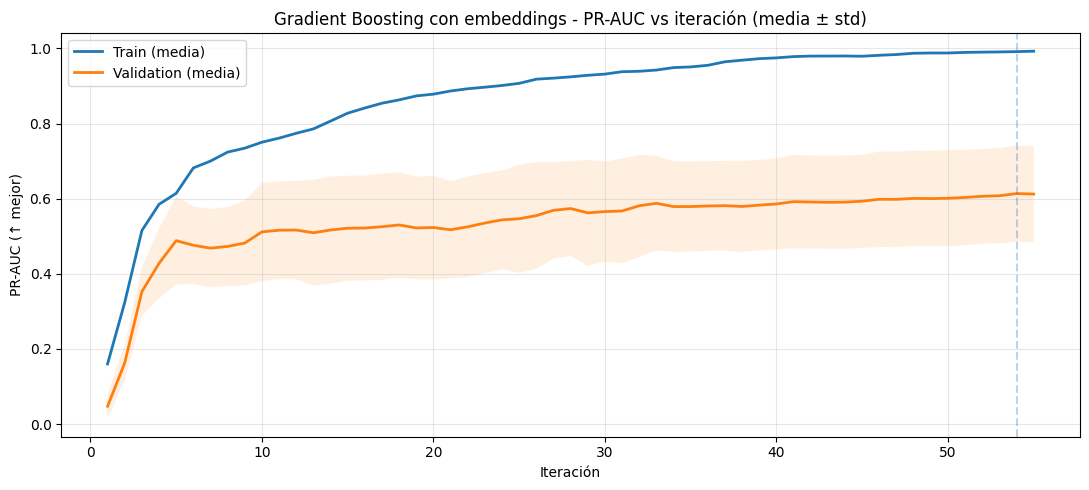

Mejor iteración (val): 55


<Figure size 640x480 with 0 Axes>

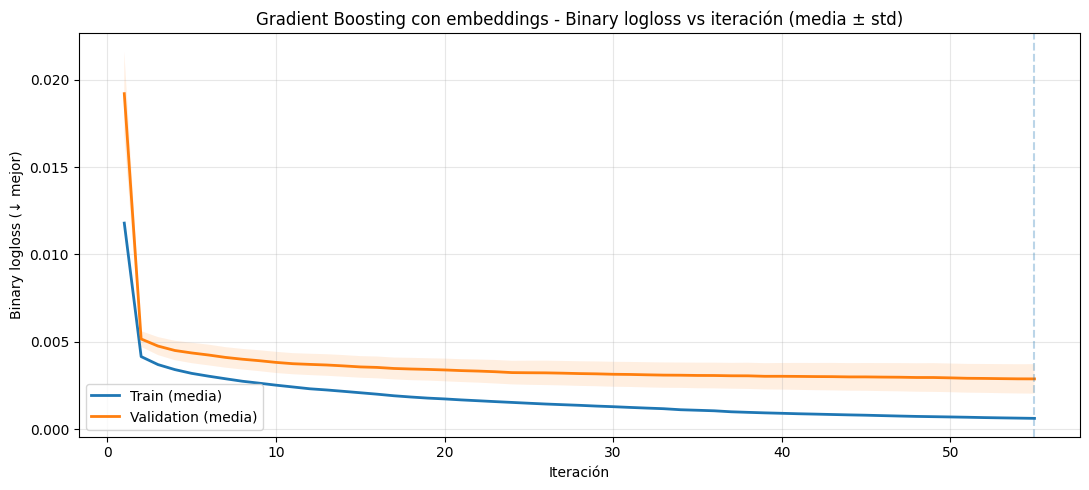

<Figure size 640x480 with 0 Axes>

In [14]:
# PR-AUC (maximizar)
aggregate_and_plot(train_ap_curves_GBEmbeddings, val_ap_curves_GBEmbeddings,
                   'Gradient Boosting con embeddings - PR-AUC vs iteración (media ± std)', 'PR-AUC', 
                   "../informes/figuras/GBEmbeddings_train_vs_validation_PRAUC.png",
                   minimize=False)

# Binary logloss (minimizar)
aggregate_and_plot(train_ll_curves_GBEmbeddings, val_ll_curves_GBEmbeddings,
                   'Gradient Boosting con embeddings - Binary logloss vs iteración (media ± std)', 'Binary logloss',
                   "../informes/figuras/GBEmbeddings_train_vs_validation_BinaryLogloss.png",
                   minimize=True)

#### Gradient Boosting

Mejor iteración (val): 110


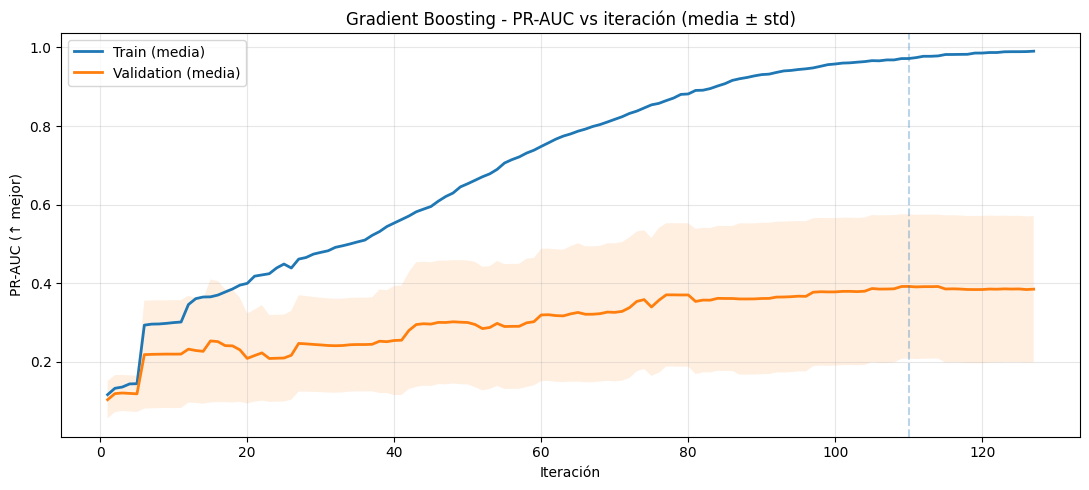

Mejor iteración (val): 113


<Figure size 640x480 with 0 Axes>

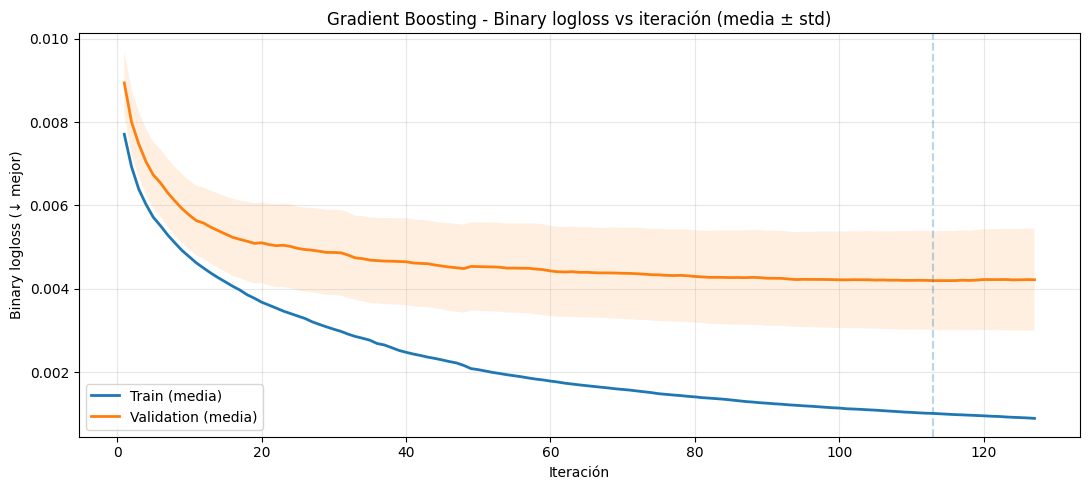

<Figure size 640x480 with 0 Axes>

In [15]:
# PR-AUC (maximizar)
aggregate_and_plot(train_ap_curves_GB, val_ap_curves_GB,
                   'Gradient Boosting - PR-AUC vs iteración (media ± std)', 'PR-AUC', 
                   "../informes/figuras/GB_train_vs_validation_PRAUC.png",
                   minimize=False)

# Binary logloss (minimizar)
aggregate_and_plot(train_ll_curves_GB, val_ll_curves_GB,
                   'Gradient Boosting - Binary logloss vs iteración (media ± std)', 'Binary logloss',
                   "../informes/figuras/GB_train_vs_validation_BinaryLogloss.png",
                   minimize=True)

#### Gradient Boosting con SMOTE

Mejor iteración (val): 94


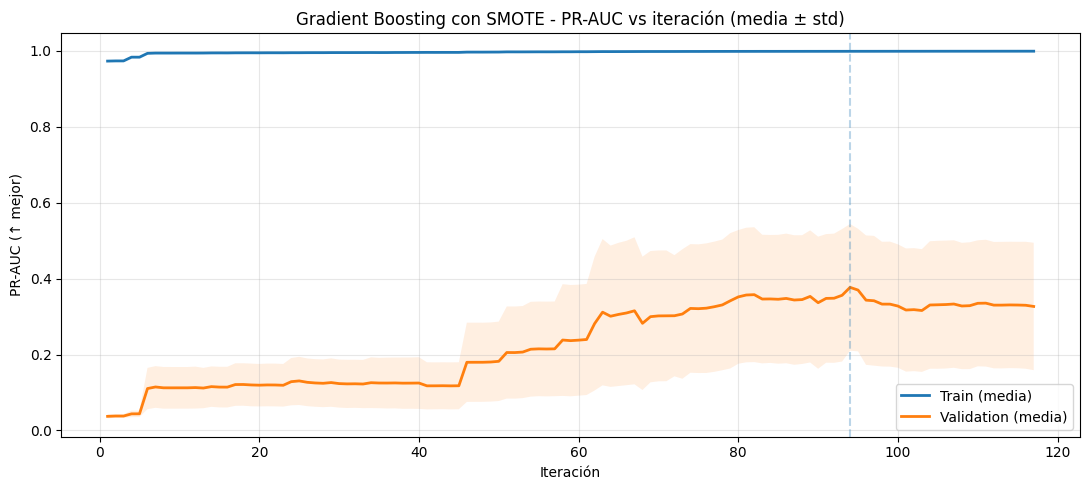

Mejor iteración (val): 117


<Figure size 640x480 with 0 Axes>

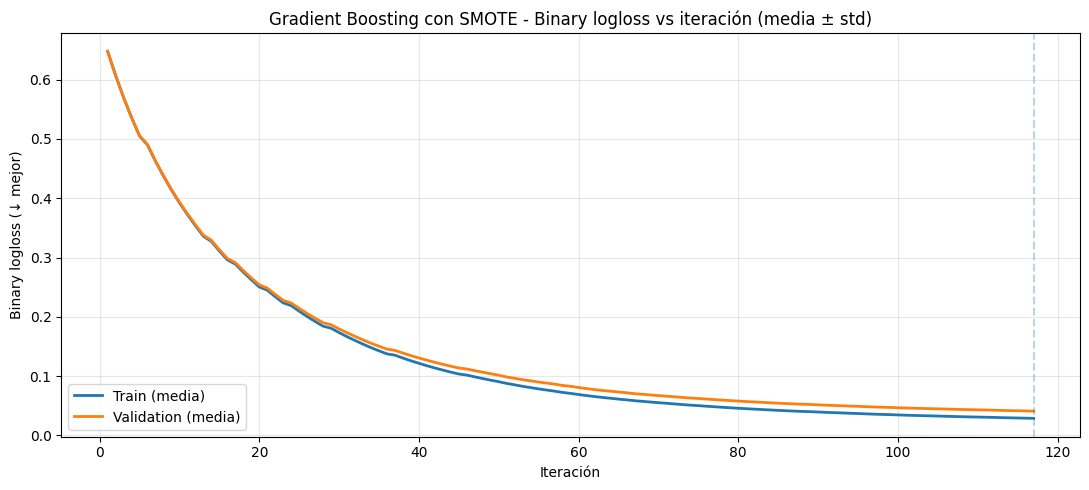

<Figure size 640x480 with 0 Axes>

In [16]:
# PR-AUC (maximizar)
aggregate_and_plot(train_ap_curves_GBSMOTE, val_ap_curves_GBSMOTE,
                   'Gradient Boosting con SMOTE - PR-AUC vs iteración (media ± std)', 'PR-AUC', 
                   "../informes/figuras/GBSMOTE_train_vs_validation_PRAUC.png",
                   minimize=False)

# Binary logloss (minimizar)
aggregate_and_plot(train_ll_curves_GBSMOTE, val_ll_curves_GBSMOTE,
                   'Gradient Boosting con SMOTE - Binary logloss vs iteración (media ± std)', 'Binary logloss',
                   "../informes/figuras/GBSMOTE_train_vs_validation_BinaryLogloss.png",
                   minimize=True)

#### Gradient Boosting con Embedddings y SMOTE

Mejor iteración (val): 116


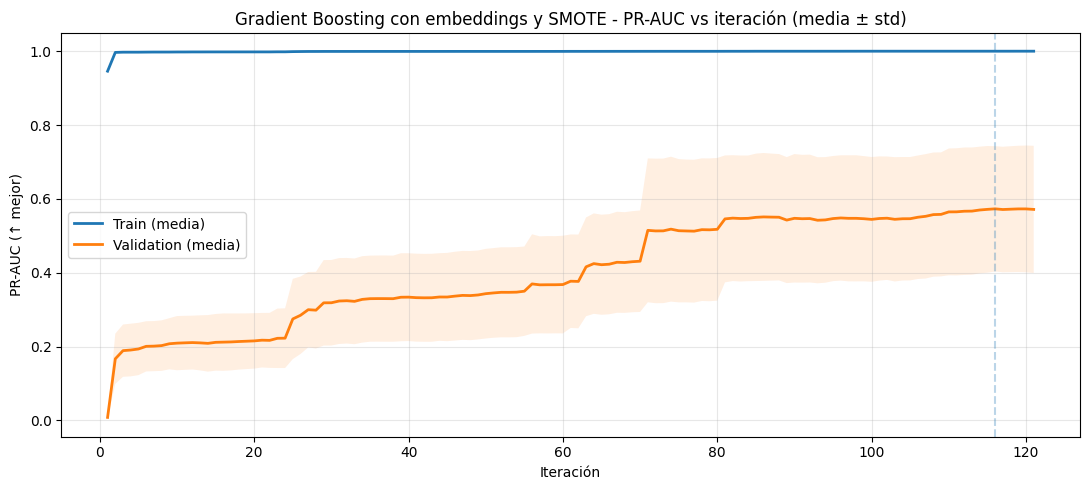

Mejor iteración (val): 121


<Figure size 640x480 with 0 Axes>

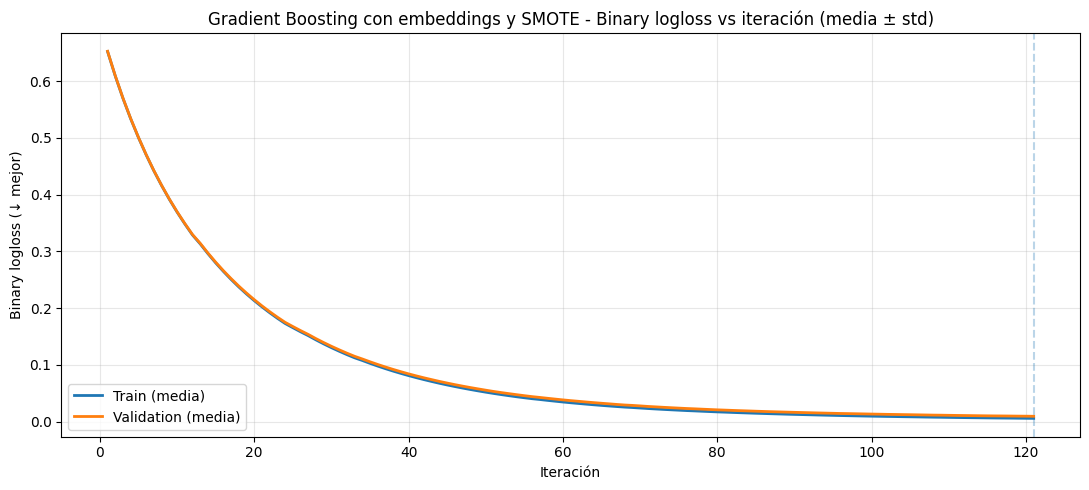

<Figure size 640x480 with 0 Axes>

In [17]:
# PR-AUC (maximizar)
aggregate_and_plot(train_ap_curves_GBEmbeddingsSMOTE, val_ap_curves_GBEmbeddingsSMOTE,
                   'Gradient Boosting con embeddings y SMOTE - PR-AUC vs iteración (media ± std)', 'PR-AUC', 
                   "../informes/figuras/GBEmbeddingsSMOTE_train_vs_validation_PRAUC.png",
                   minimize=False)

# Binary logloss (minimizar)
aggregate_and_plot(train_ll_curves_GBEmbeddingsSMOTE, val_ll_curves_GBEmbeddingsSMOTE,
                   'Gradient Boosting con embeddings y SMOTE - Binary logloss vs iteración (media ± std)', 'Binary logloss',
                   "../informes/figuras/GBEmbeddingsSMOTE_train_vs_validation_BinaryLogloss.png",
                   minimize=True)

## Testear resultados finales

In [18]:
def testear_modelo(X_tr, y_train, X_va, y_val, X_te, y_test, best_iters, thr_f1, thr_f2, thr_f05):
    """Entrenamiento final y evaluación en TEST"""

    params = {
        'objective': 'binary',
        'metric': ['average_precision', 'binary_logloss'],
        'first_metric_only': True,
        'learning_rate': 0.05,
        'num_leaves': 8,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.9,
        'bagging_freq': 1,
        'min_data_in_leaf': 100,
        'seed': RANDOM_STATE,
        'num_threads': -1,
    }

    # 1) num_boost_round robusto desde la CV
    final_nrounds = int(median(best_iters))

    # 2) Entrenamiento FINAL en TRAIN+VAL (sin early stopping)
    X_tv = np.vstack([X_tr, X_va])
    y_tv = np.concatenate([y_train, y_val])
    dall = lgb.Dataset(X_tv, label=y_tv, free_raw_data=False)

    clf_final = lgb.train(
        params,
        dall,
        num_boost_round=final_nrounds
    )

    # 3) Umbrales FIJOS (desde CV)
    thr_f1_med  = float(median(thr_f1))
    thr_f2_med  = float(median(thr_f2))
    thr_f05_med = float(median(thr_f05))

    # 4) Evaluación en TEST
    y_prob_te = clf_final.predict(X_te, num_iteration=final_nrounds)

    pr_auc_te = average_precision_score(y_test, y_prob_te)
    print(f"\nTEST — PR-AUC={pr_auc_te:.4f}")

    def metrics_at_threshold(y_true, y_prob, thr, beta):
        y_pred = (y_prob >= thr).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f = fbeta_score(y_true, y_pred, beta=beta, zero_division=0)
        return f, p, r, thr

    f1_te,  p1,  r1,  t1  = metrics_at_threshold(y_test, y_prob_te, thr_f1_med,  1.0)
    f2_te,  p2,  r2,  t2  = metrics_at_threshold(y_test, y_prob_te, thr_f2_med,  2.0)
    f05_te, p05, r05, t05 = metrics_at_threshold(y_test, y_prob_te, thr_f05_med, 0.5)

    print(f"TEST (umbral CV) — F1={f1_te:.4f}  (P={p1:.4f},  R={r1:.4f},  thr={t1:.4f})")
    print(f"TEST (umbral CV) — F2={f2_te:.4f}  (P={p2:.4f},  R={r2:.4f},  thr={t2:.4f})")
    print(f"TEST (umbral CV) — F0.5={f05_te:.4f} (P={p05:.4f}, R={r05:.4f}, thr={t05:.4f})")

    return clf_final, y_prob_te

#### GB + Embeddings secuenciales

In [19]:
X_tr = np.hstack([tab_train.values, Z_train])
X_va = np.hstack([tab_val.values,   Z_val])
X_te = np.hstack([tab_test.values,  Z_test])

clf_GBEmbeddings, y_prob_GBEmbeddings = testear_modelo(X_tr, y_train, 
               X_va, y_val, 
               X_te, y_test, 
               best_iters_GBEmbeddings, 
               thr_f1_GBEmbeddings, 
               thr_f2_GBEmbeddings, 
               thr_f05_GBEmbeddings)


[LightGBM] [Info] Number of positive: 81, number of negative: 84160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 84241, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000962 -> initscore=-6.946026
[LightGBM] [Info] Start training from score -6.946026

TEST — PR-AUC=0.4402
TEST (umbral CV) — F1=0.5417  (P=0.4643,  R=0.6500,  thr=0.1446)
TEST (umbral CV) — F2=0.5603  (P=0.3611,  R=0.6500,  thr=0.0722)
TEST (umbral CV) — F0.5=0.5435 (P=0.5556, R=0.5000, thr=0.5104)


#### GB

In [20]:
X_tr = tab_train.values
X_va = tab_val.values
X_te = tab_test.values

clf_GB, y_prob_GB = testear_modelo(X_tr, y_train, 
               X_va, y_val, 
               X_te, y_test, 
               best_iters_GB, 
               thr_f1_GB, 
               thr_f2_GB, 
               thr_f05_GB)

[LightGBM] [Info] Number of positive: 81, number of negative: 84160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 84241, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000962 -> initscore=-6.946026
[LightGBM] [Info] Start training from score -6.946026

TEST — PR-AUC=0.3301
TEST (umbral CV) — F1=0.3200  (P=0.8000,  R=0.2000,  thr=0.5909)
TEST (umbral CV) — F2=0.3211  (P=0.2414,  R=0.3500,  thr=0.1945)
TEST (umbral CV) — F0.5=0.5556 (P=1.0000, R=0.2000, thr=0.6261)


#### GB + SMOTE

In [21]:
X_tr = tab_train.values
X_va = tab_val.values
X_te = tab_test.values

clf_GBSMOTE, y_prob_GBSMOTE = testear_modelo(X_tr, y_train, 
               X_va, y_val, 
               X_te, y_test, 
               best_iters_GBSMOTE, 
               thr_f1_GBSMOTE, 
               thr_f2_GBSMOTE, 
               thr_f05_GBSMOTE)

[LightGBM] [Info] Number of positive: 81, number of negative: 84160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 84241, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000962 -> initscore=-6.946026
[LightGBM] [Info] Start training from score -6.946026

TEST — PR-AUC=0.3359
TEST (umbral CV) — F1=0.0952  (P=1.0000,  R=0.0500,  thr=0.9752)
TEST (umbral CV) — F2=0.0617  (P=1.0000,  R=0.0500,  thr=0.9683)
TEST (umbral CV) — F0.5=0.0000 (P=0.0000, R=0.0000, thr=0.9858)


#### GB + Embeddings secuenciales + SMOTE

In [22]:
X_tr = np.hstack([tab_train.values, Z_train])
X_va = np.hstack([tab_val.values,   Z_val])
X_te = np.hstack([tab_test.values,  Z_test])

clf_GBEmbeddingsSMOTE, y_prob_GBEmbeddingsSMOTE = testear_modelo(X_tr, y_train, 
               X_va, y_val, 
               X_te, y_test, 
               best_iters_GBEmbeddingsSMOTE, 
               thr_f1_GBEmbeddingsSMOTE, 
               thr_f2_GBEmbeddingsSMOTE, 
               thr_f05_GBEmbeddingsSMOTE)

[LightGBM] [Info] Number of positive: 81, number of negative: 84160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 84241, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000962 -> initscore=-6.946026
[LightGBM] [Info] Start training from score -6.946026

TEST — PR-AUC=0.4371
TEST (umbral CV) — F1=0.2500  (P=0.7500,  R=0.1500,  thr=0.9856)
TEST (umbral CV) — F2=0.3723  (P=0.5000,  R=0.3500,  thr=0.8238)
TEST (umbral CV) — F0.5=0.4167 (P=0.7500, R=0.1500, thr=0.9883)


### Guardar modelos y resultados

In [23]:
data = {
    'evals_result_GBEmbeddings': evals_result_GBEmbeddings,
    'evals_result_GB': evals_result_GB,
    'evals_result_GBSMOTE': evals_result_GBSMOTE,
    'evals_result_GBEmbeddingsSMOTE': evals_result_GBEmbeddingsSMOTE,
    'clf_GBEmbeddings': clf_GBEmbeddings,
    'clf_GB': clf_GB,
    'clf_GBSMOTE': clf_GBSMOTE,
    'clf_GBEmbeddingsSMOTE': clf_GBEmbeddingsSMOTE,
    'y_prob_GBEmbeddings': y_prob_GBEmbeddings,
    'y_prob_GB': y_prob_GB,
    'y_prob_GBSMOTE': y_prob_GBSMOTE,
    'y_prob_GBEmbeddingsSMOTE': y_prob_GBEmbeddingsSMOTE,
    'X_te_embs': np.hstack([tab_test.values,  Z_test]),
    'X_te': tab_test.values,
    'y_test': y_test,
}

# Guardar en pickle
with open('../app/modelos/modelos_lightgbm.pkl', 'wb') as f:
    pickle.dump(data, f)